# Lorenz

An example which tries to align internal state estimates of DEM with a Lorenz
attractor. Reproduction of this notebook from the dempy package:

    https://github.com/johmedr/dempy/blob/8689cfa99a472bfdbd78c1901e950a563ec1b7c1/notebooks/Lorenz%20model.ipynb

It's also very similar to the 'virtual birdsong' experiment from

    K. Friston and S. Kiebel, “Predictive coding under the free-energy
    principle,” Philos Trans R Soc Lond B Biol Sci, vol. 364, no. 1521, pp.
    1211–1221, May 2009, doi: 10.1098/rstb.2008.0300.


In [1]:
import jax.numpy as jnp
import numpy as np
from dem.algo import DEMInput, DEMState, extract_dynamic
from dem.dummy import simulate_system
from jax import jit
from matplotlib import pyplot as plt


In [2]:
%matplotlib inline

## Simulate the problem

Below we simulate the Lorenz attractor system we will later invert.

In [3]:
## Prior expectations (and true values)
params_true = np.array([18.0, 18.0, 46.92, 2.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0])
x0_true = np.array([0.9, 0.8, 30])


# Lorenz attractor transition function f
@jit
def lorenz(x, v, P):
    x0 = P[0] * x[1] - P[1] * x[0]
    x1 = P[2] * x[0] - P[3] * x[2] * x[0] - P[4] * x[1]
    x2 = P[5] * x[0] * x[1] - P[6] * x[2]

    return jnp.array([x0, x1, x2]) / 128.0


# Observation function g
@jit
def obs(x, v, P):
    return x @ P[-3:]


def f_true(x, v):
    return lorenz(x, v, params_true)


def g_true(x, v):
    return obs(x, v, params_true)


rng = np.random.default_rng(215)
n = 1024
dt = 1
vs = np.zeros((n, 1))
noise_prec = np.exp(32)
noise_var = 1 / noise_prec
noise_sd = np.sqrt(noise_var)
w_sd = noise_sd
z_sd = 1
noise_temporal_sig = 1 / 8
ts, xs, ys, ws, zs = simulate_system(
    f_true, g_true, x0_true, dt, vs, w_sd, z_sd, noise_temporal_sig, rng=rng
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Now we can plot the underlying states that we will try to find using DEM

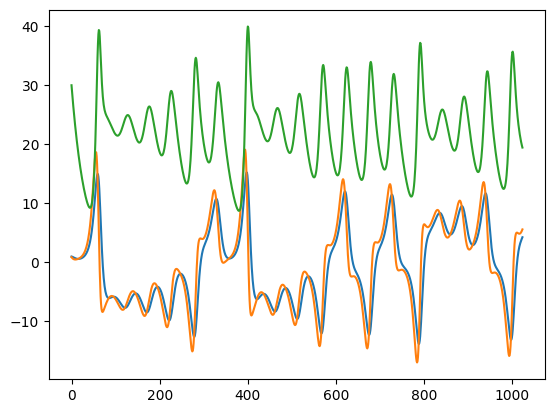

In [4]:
plt.plot(ts, xs)

...and the single system output that DEM will see over the course of the procedure. The single series below should suffice for the D step of DEM to converge to the three states, given that we already know all of the parameters.

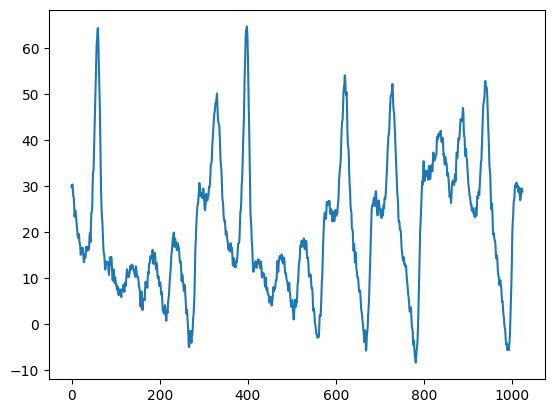

In [5]:
plt.plot(ts, ys)

## Define the DEM model

Now we define the DEM model, with necessary functions and priors.

In [6]:
# the DEM optimizer expects f and g to take and return shape (-1, 1)
def f_dem(x, v, P):
    x = x.reshape(-1)
    v = v.reshape(-1)
    return lorenz(x, v, P).reshape(-1, 1)


def g_dem(x, v, P):
    x = x.reshape(-1)
    v = v.reshape(-1)
    return obs(x, v, P).reshape(-1, 1)


p = 4
d = 2  # d is irrelevant, because the inputs v are all zero

x0_test = np.array([12, 13, 16]).reshape(-1, 1)
p_v = np.exp(5).reshape((1, 1))

eta_theta = params_true  # prior equal to parameters, so we assume that they are known
p_theta = np.diag(np.ones(eta_theta.shape)) * np.exp(64)  # high precision prior
eta_lambda = np.zeros(2)
p_lambda = np.eye(2) * np.exp(3)

m_x = 3
m_v = 1  # v are all zero in any case
m_y = 1

dem_input = DEMInput(
    dt=dt,
    m_x=m_x,
    m_v=m_v,
    m_y=m_y,
    p=p,
    d=d,
    ys=ys,
    eta_v=vs,
    p_v=p_v,
    eta_theta=eta_theta,
    p_theta=p_theta,
    eta_lambda=eta_lambda,
    p_lambda=p_lambda,
    f=f_dem,
    g=g_dem,
    noise_temporal_sig=noise_temporal_sig,
)

dem_state = DEMState.from_input(dem_input, x0=x0_test)


## Run D step

We will now run the D step of DEM, so we'll try to infer the trajectories of the three states only from the single output.

In [7]:
# Run only the D step of DEM, since we assume the parameters to be already known
lr_dynamic = 1
dem_state.step_d(lr_dynamic)

/tmp/ipykernel_16467/3748848002.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


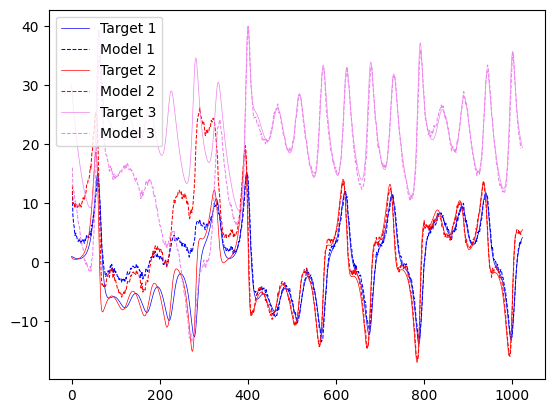

In [8]:
# Extract and plot the trajectories
mu_xs1, sig_xs1, mu_vs1, sig_vs1, ts1 = extract_dynamic(dem_state)

fig, ax = plt.subplots()
ax.plot(ts, xs[:, 0], label="Target 1", color="blue", linewidth=0.5)
ax.plot(
    ts1, mu_xs1[:, 0], label="Model 1", color="blue", linestyle="--", linewidth=0.75
)
ax.plot(ts, xs[:, 1], label="Target 2", color="red", linewidth=0.5)
ax.plot(ts1, mu_xs1[:, 1], label="Model 2", color="red", linestyle="--", linewidth=0.75)
ax.plot(ts, xs[:, 2], label="Target 3", color="violet", linewidth=0.5)
ax.plot(
    ts1, mu_xs1[:, 2], label="Model 3", color="violet", linestyle="--", linewidth=0.75
)
ax.legend()
fig.show()

As we can see above, DEM is able to converge to the target states given observations of only the single output $x + y + z$.

Unfortunately, the current implementation is not able to do the E, M, and precision steps on this problem, because the memory usage explodes :(

In [9]:
# Only run this code if you have a lot of RAM (~20+ GB)
# print("Computing free action...")
# f_bar = dem_state.free_action()